# Sumador de Draper QFT

In [27]:
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
IBMQ.save_account('b6a64fd92bc0d0f5af8011f1800820500e02cfafc29bb98e2c13c746b883ffa885b544d9e0d286cac28786d034872f25f77be296e88ac9e8bef093cb659536fb')

configrc.store_credentials:WARNING:2021-04-17 23:46:02,192: Credentials already present. Set overwrite=True to overwrite.


In [34]:
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)   # anhadimos la puerta H
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n) # pasamos el numero, el qubit de control
                                            # y luego el objetivo.
    circuit.barrier(range(n))
    qft_rotations(circuit, n)

In [35]:
def swap_registers(circuit, n):
    for qubit in range(n//2): # tenemos que hacer el swap para queden bien 
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

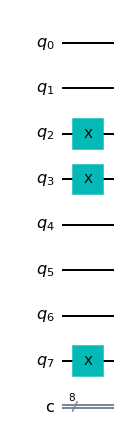

In [53]:
n = 8
nA = 4
qc = QuantumCircuit(n,n)

#Nuestro numero A seria |0011> (3)
qc.x(2)
qc.x(3)

#nuestro numeroB seria |0001> (1)
qc.x(7)

qc.draw('mpl')


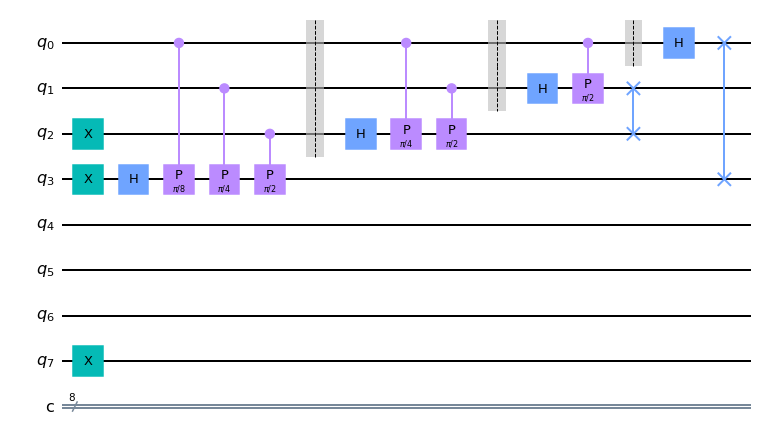

In [54]:
qft(qc,nA)
qc.draw('mpl')

In [55]:
def adder(circuit, n):
  # circuit.cp(pi/2**(0), n  ,0)
  # circuit.cp(pi/2**(1), n+1,0)
  # circuit.cp(pi/2**(2), n+2,0)
  # circuit.cp(pi/2**(3), n+3,0)
  # 
  # circuit.cp(pi/2**(0), n+1,1)
  # circuit.cp(pi/2**(1), n+2,1)
  # circuit.cp(pi/2**(2), n+3,1)
  # 
  # circuit.cp(pi/2**(0), n+2,2)
  # circuit.cp(pi/2**(1), n+3,2)
  # 
  # circuit.cp(pi/2**(0), n+3,3)
    
    circuit.cp(pi/2**(0), n  ,0)
    circuit.cp(pi/2**(1), n+1,0)
    circuit.cp(pi/2**(2), n+2,0)
    circuit.cp(pi/2**(3), n+3,0)
    circuit.barrier(range(2*n))
    
    circuit.cp(pi/2**(0), n+1,1)
    circuit.cp(pi/2**(1), n+2,1)
    circuit.cp(pi/2**(2), n+3,1)
    circuit.barrier(range(2*n))
   
    circuit.cp(pi/2**(0), n+2,2)
    circuit.cp(pi/2**(1), n+3,2)
    circuit.barrier(range(2*n))
  
    circuit.cp(pi/2**(0), n+3,3)
    
    circuit.barrier(range(2*n))

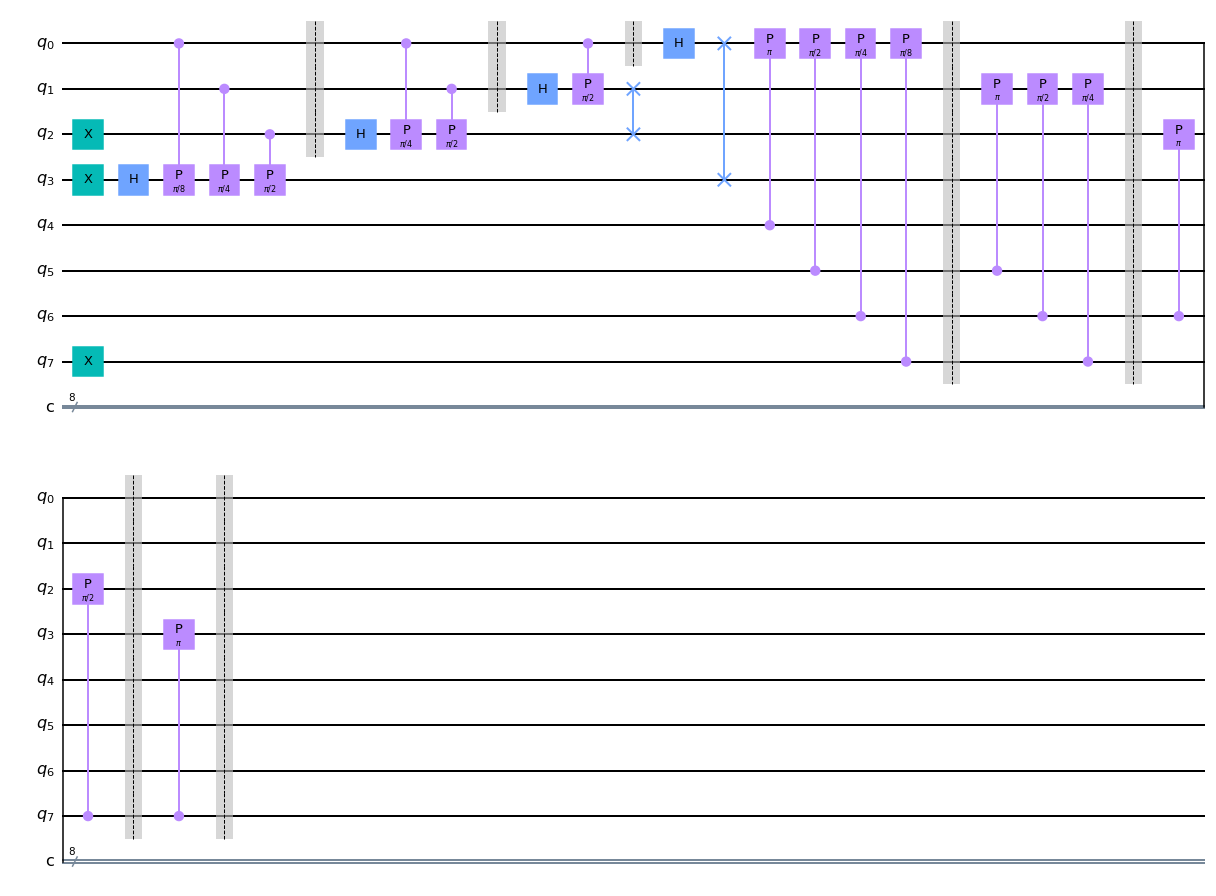

In [56]:
adder(qc, nA)
qc.draw('mpl')

In [57]:
qc+= qft(QuantumCircuit(n,n),nA).inverse()

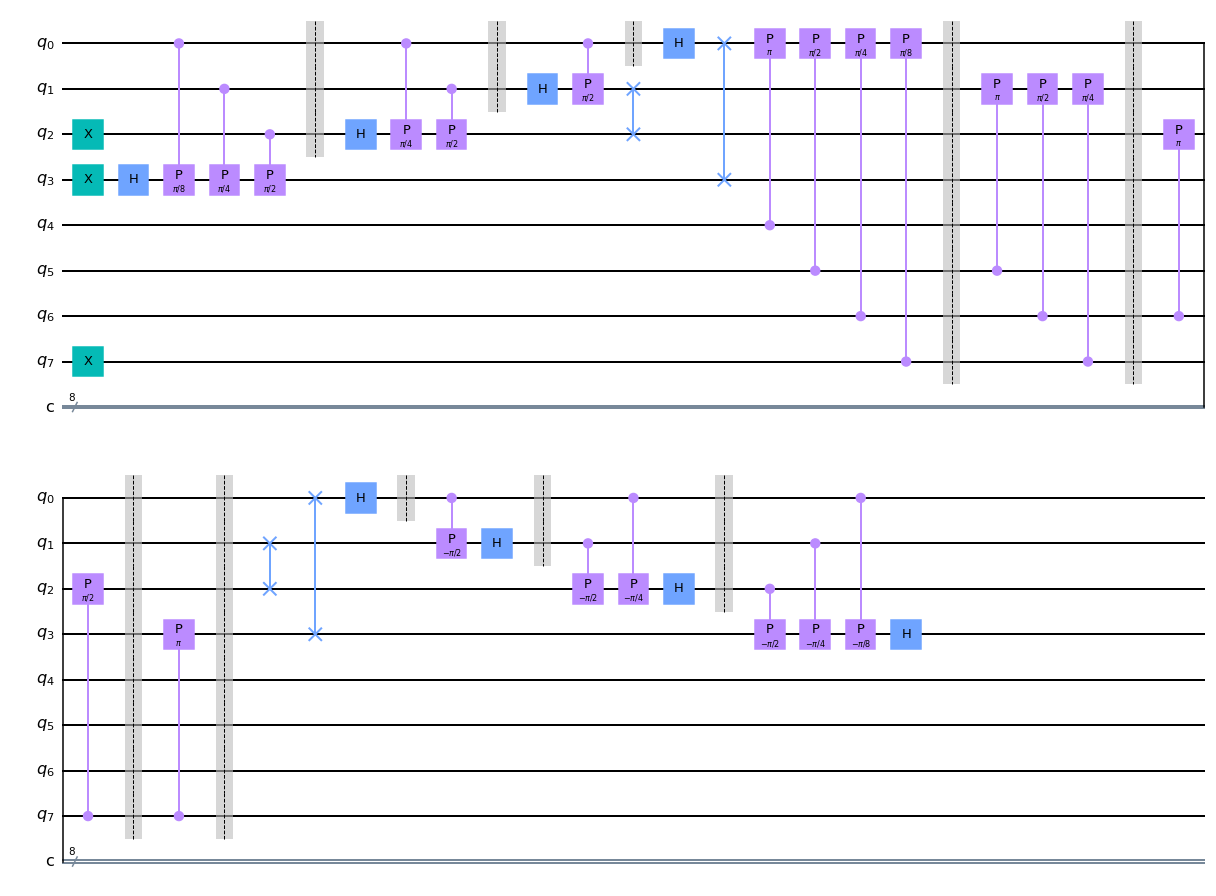

In [58]:
qc.draw('mpl')

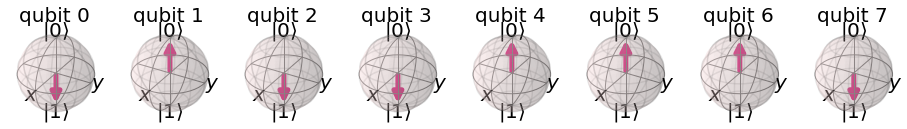

In [61]:
sv_sim = Aer.get_backend("statevector_simulator")
qobj = assemble(qc)
statevector = sv_sim.run(qobj).result().get_statevector()
plot_bloch_multivector(statevector)

Como vemos los bits mas significativos, da nuestro numero 4.

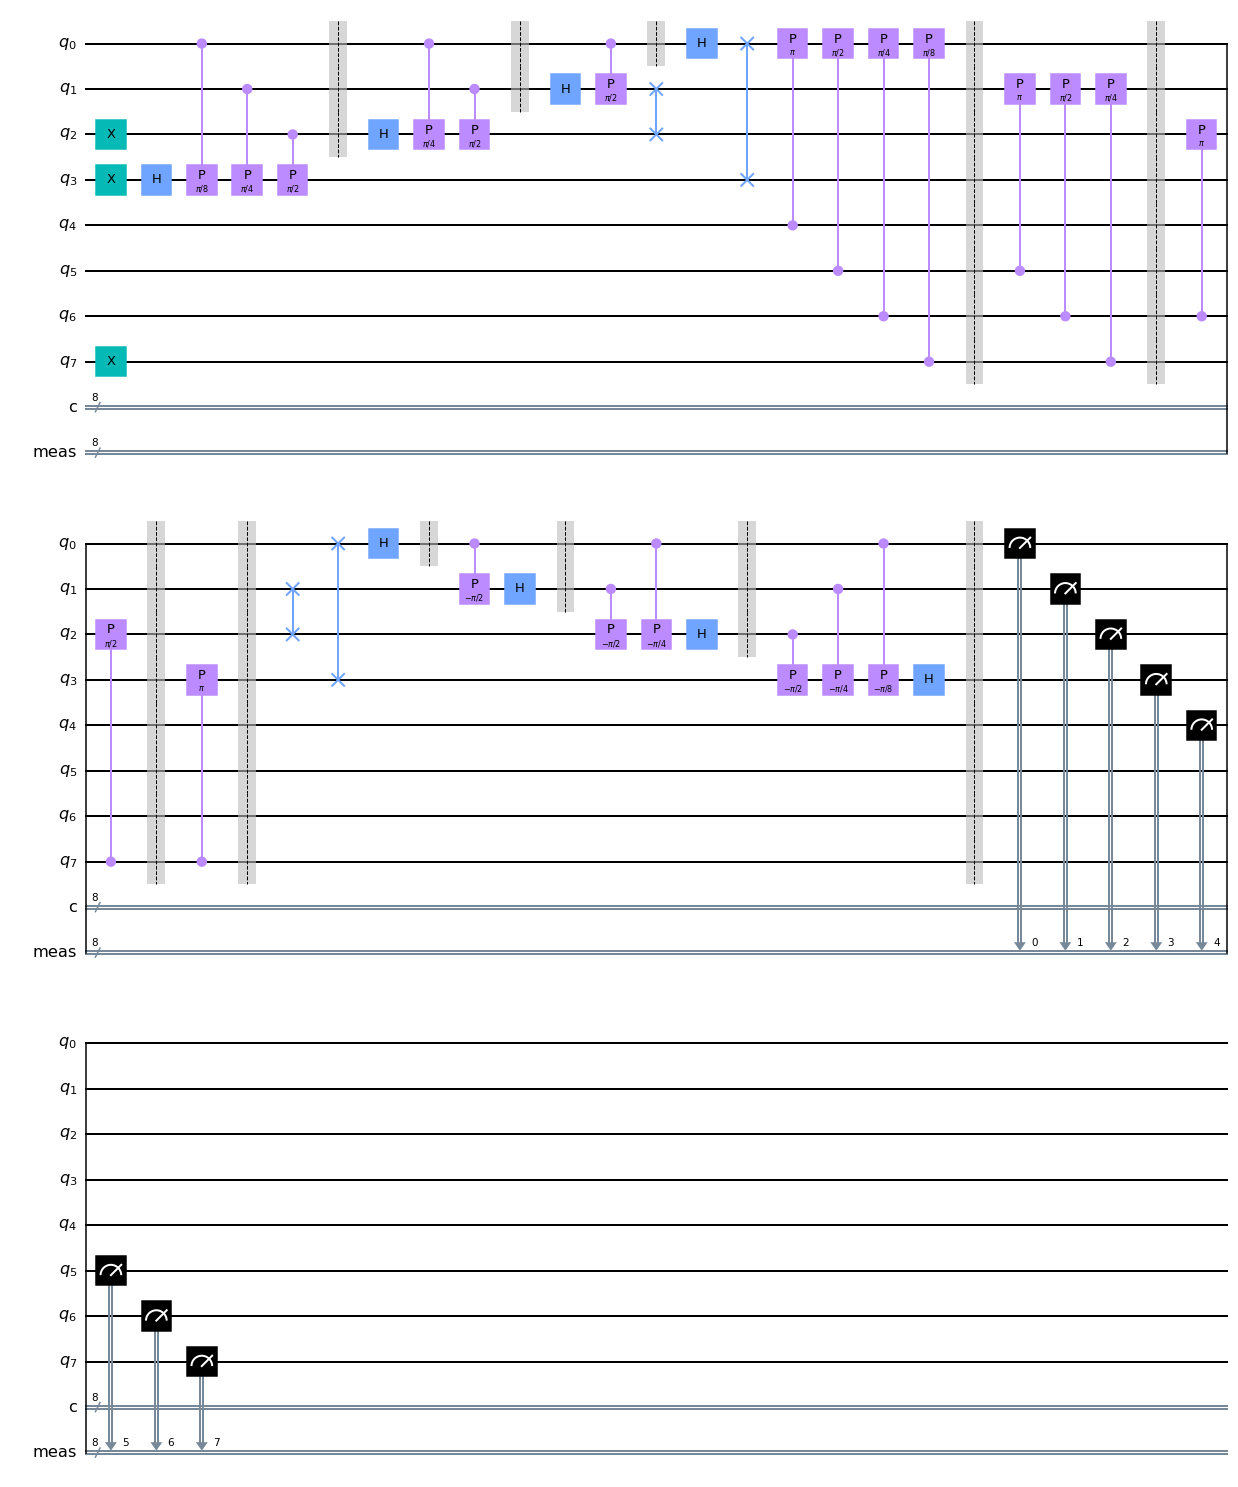

In [60]:
qc.measure_all()
qc.draw('mpl')

In [29]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 7 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2021-04-17 23:46:35,873: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_16_melbourne


In [30]:
shots = 2048
transpiled_qc = transpile(qc, backend, optimization_level=3)
qobj = assemble(transpiled_qc, shots=shots)
job = backend.run(qobj)
job_monitor(job)

Job Status: job has successfully run


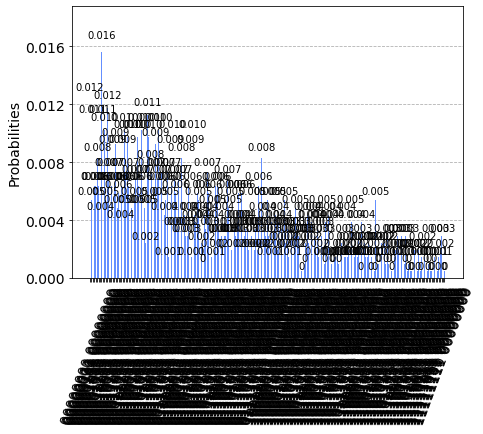

In [32]:
counts = job.result().get_counts()
plot_histogram(counts)